In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import itertools
import random

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

def seasonal_check(df):

  decomposition = seasonal_decompose(df.incremental_cases, model = 'additive', period = 30)
  plt.figure(figsize=(12, 8))

  plt.subplot(4, 1, 1)
  plt.plot(df.date, df.incremental_cases, label='Original', color='blue')
  plt.legend(loc='upper left')
  plt.title('Original Time Series')

  plt.subplot(4, 1, 2)
  plt.plot(df.date, decomposition.trend, label='Trend', color='red')
  plt.legend(loc='upper left')
  plt.title('Trend Component')

  plt.subplot(4, 1, 3)
  plt.plot(df.date, decomposition.seasonal, label='Seasonal', color='green')
  plt.legend(loc='upper left')
  plt.title('Seasonal Component')

  plt.subplot(4, 1, 4)
  plt.plot(df.date, decomposition.resid, label='Residual', color='purple')
  plt.legend(loc='upper left')
  plt.title('Residual Component')

  plt.tight_layout()
  plt.show()

data = pd.read_csv('finalized_county.csv').iloc[:, 1:]

tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


# New York City

(-4.027742630367559, 0.0012720104380451068)


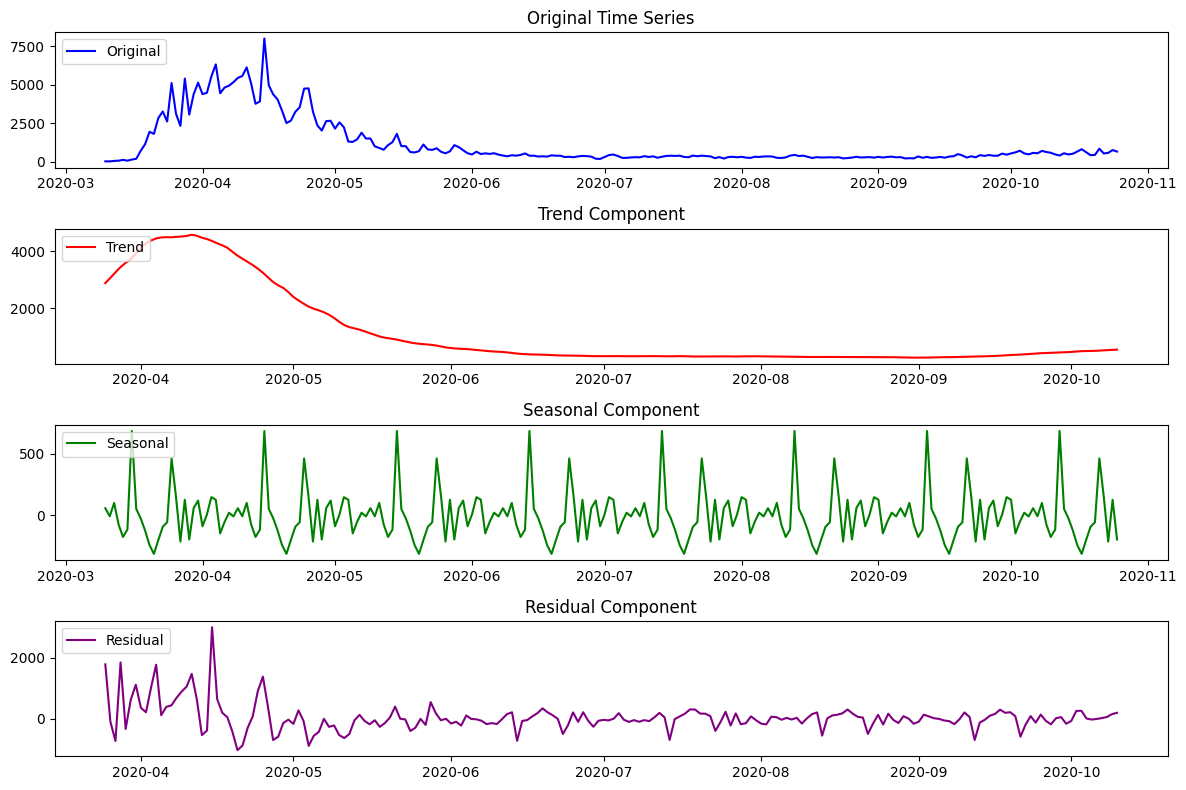

In [ ]:
nyc = data[data['county'] == 'New York City'].loc[:, ['date', 'incremental_cases']]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

# NYC data is stationary without any differencing
print(stationary_test(train.incremental_cases))

# check for seasonality
seasonal_check(train)

In [ ]:
# prepare data using a combination of d = [0, 1, 2], D = [0, 1, 2], and m = [0, 30]
def differencing(timeseries, m):
    info = []
    for i in range(3):
        timeseries.name = f"d{i}_D0_m0"
        info.append(timeseries)
        timeseries = timeseries.diff()

    for i in m:
        for j in range(3):
            timeseries = info[j].diff(periods=i)
            timeseries.name = f"d{j}_D1_m{i}"
            info.append(timeseries)

    for i in m:
        for j in range(3):
            timeseries = info[j+3].diff(periods=i)
            timeseries.name = f"d{j}_D2_m{i}"
            info.append(timeseries)

    return pd.DataFrame(info).T

diff_series = differencing(train.incremental_cases, [30])
diff_series

,d0_D0_m0,d1_D0_m0,d2_D0_m0,d0_D1_m30,d1_D1_m30,d2_D1_m30,d0_D2_m30,d1_D2_m30,d2_D2_m30
1890,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,15.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1892,44.0,29.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
1893,59.0,15.0,-14.0,NaN,NaN,NaN,NaN,NaN,NaN
1894,114.0,55.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2115,842.0,406.0,390.0,580.0,545.0,441.0,583.0,665.0,460.0
2116,531.0,-311.0,-717.0,183.0,-397.0,-942.0,123.0,-460.0,-1125.0
2117,570.0,39.0,350.0,289.0,106.0,503.0,218.0,95.0,555.0
2118,752.0,182.0,143.0,330.0,41.0,-65.0,139.0,-79.0,-174.0


In [ ]:
# check the stationary status of each combination
def adf_summary(diff_series):
    summary = []
    for i in diff_series:
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)

    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]

    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)

    return summary

# only select combinations that are stationary
summary = adf_summary(diff_series)
summary_passed = summary[summary["p-value"] < 0.05]

index_list = pd.Index.tolist(summary_passed.index)
passed_series = diff_series[index_list]
ps = passed_series.sort_index(axis=1)

<Axes: title={'center': 'Possible AR Terms'}, xlabel='nth lag', ylabel='Sum of PACF'>

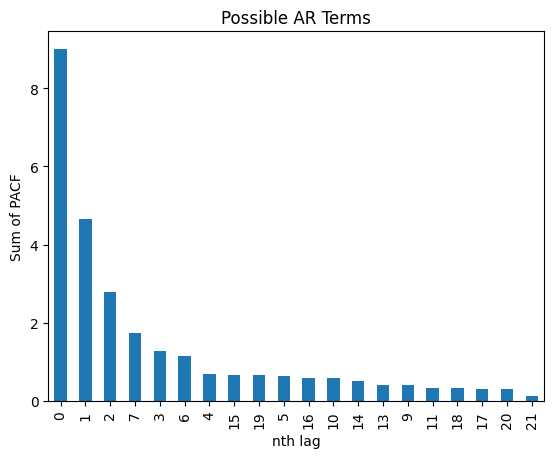

In [ ]:
# visualize the combined ACF and PACF plots to discern possible values for p, q, P, Q

df_sp_p = pd.DataFrame()
AR = []
for i in ps:
    PACF, PACF_ci = pacf(ps[i].dropna(), alpha=0.05, method='ywm')

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF

    # find positions of significant spikes ~ possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]

    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

df_sp_q = pd.DataFrame()
MA = []
for i in ps:
    ACF, ACF_ci = acf(ps[i].dropna(), alpha=0.05)

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF

    # find positions of significant spikes ~ possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]

    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# visualize sums of values of significant spikes by nlags in PACF plots
df_sp_p.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible AR Terms', xlabel='nth lag', ylabel='Sum of PACF')

<Axes: title={'center': 'Possible MA Terms'}, xlabel='nth lag', ylabel='Sum of ACF'>

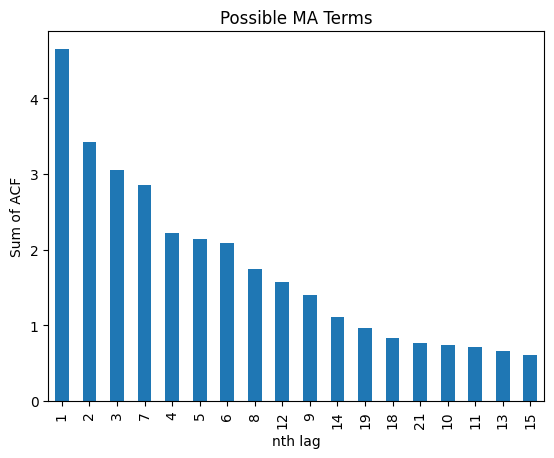

In [ ]:
# visualize sums of values of significant spikes by nlags in ACF plots
df_sp_q.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible MA Terms', xlabel='nth lag', ylabel='Sum of ACF')

### ARIMA

In [ ]:
# train ARIMA model with 3-fold CV and possible p, q terms inferred from the above graphs
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 1, 2, 7]
q_values = [1, 2, 3, 7]

best_score, best_param = float("inf"), None

for p in p_values:
    for q in q_values:
      all_mse = 0
      # the "d" parameter is pre-chosen as 0 since NYC is stationary without any differencing
      param = (p, 0, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 0, 1) with mean MSE: 1643417.5682633205
params: (0, 0, 2) with mean MSE: 1623439.725968415
params: (0, 0, 3) with mean MSE: 1591112.9497886507
params: (0, 0, 7) with mean MSE: 1517079.234451683
params: (1, 0, 1) with mean MSE: 306499.86170766456
params: (1, 0, 2) with mean MSE: 272460.26428888657
params: (1, 0, 3) with mean MSE: 304978.5329644114
params: (1, 0, 7) with mean MSE: 424248.6749945281
params: (2, 0, 1) with mean MSE: 282693.2828077785
params: (2, 0, 2) with mean MSE: 270250.14245974773
params: (2, 0, 3) with mean MSE: 305099.7819400895
params: (2, 0, 7) with mean MSE: 1857542.9436629005
params: (7, 0, 1) with mean MSE: 225808.5848774511
params: (7, 0, 2) with mean MSE: 239146.26448959517
params: (7, 0, 3) with mean MSE: 252692.55998072648
params: (7, 0, 7) with mean MSE: 1017014.8681420424
Best ARIMA parameters: (7, 0, 1) with mean MSE: 225808.5848774511


<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

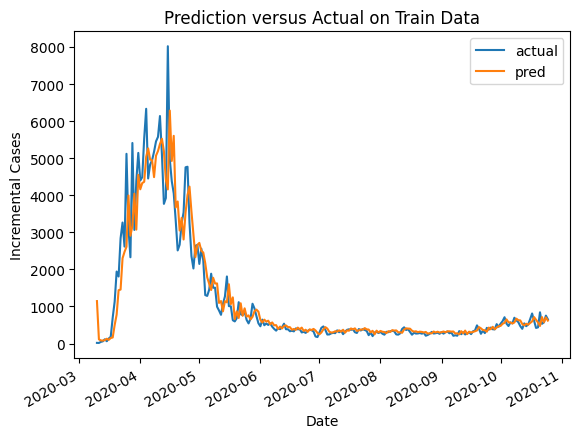

In [ ]:
model = ARIMA(train.incremental_cases, order=(7, 0, 1)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.45029535258366915


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

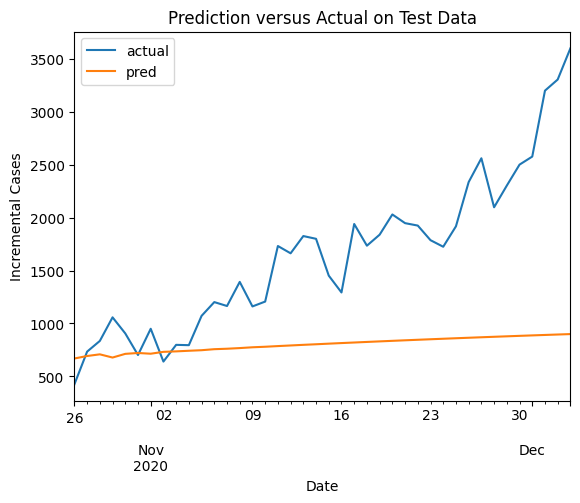

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on test
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

### SARIMA

In [ ]:
p_values = [0, 1, 2, 7]
q_values = [1, 2, 3, 7]
P_values = range(0, 3)
Q_values = range(0, 3)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    for P in P_values:
      for Q in Q_values:
        all_mse = 0
        param = (p, 0, q)
        s_param = (P, 0, Q, 30)
        for train_index, val_index in tscv.split(train):
          train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
          model = SARIMAX(train_data.incremental_cases, order = param, seasonal_order = s_param,
                          initialization ='approximate_diffuse').fit()
          mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
          all_mse = all_mse + mse
        print(f'params: {(param, s_param)} with mean MSE: {all_mse / 3}')
        if all_mse / 3 < best_score:
          best_score, best_param, = all_mse / 3, (param, s_param)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: ((0, 0, 1), (0, 0, 0, 30)) with mean MSE: 151655.33285031698
params: ((0, 0, 1), (0, 0, 1, 30)) with mean MSE: 109396.89013075817
params: ((0, 0, 1), (0, 0, 2, 30)) with mean MSE: 110329.82751851525
params: ((0, 0, 1), (1, 0, 0, 30)) with mean MSE: 92228.6350123743
params: ((0, 0, 1), (1, 0, 1, 30)) with mean MSE: 87353.57571838074
params: ((0, 0, 1), (1, 0, 2, 30)) with mean MSE: 100115.39081705797
params: ((0, 0, 1), (2, 0, 0, 30)) with mean MSE: 121007.33685383697
params: ((0, 0, 1), (2, 0, 1, 30)) with mean MSE: 111976.07537361297
params: ((0, 0, 1), (2, 0, 2, 30)) with mean MSE: 307643.86109458003
params: ((0, 0, 2), (0, 0, 0, 30)) with mean MSE: 150405.99399683365
params: ((0, 0, 2), (0, 0, 1, 30)) with mean MSE: 107732.02761776734
params: ((0, 0, 2), (0, 0, 2, 30)) with mean MSE: 118058.77979342751
params: ((0, 0, 2), (1, 0, 0, 30)) with mean MSE: 116121.36104871969
params: ((0, 0, 2), (1, 0, 1, 30)) with mean MSE: 106909.97223192685
params: ((0, 0, 2), (1, 0, 2, 30)) wi

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

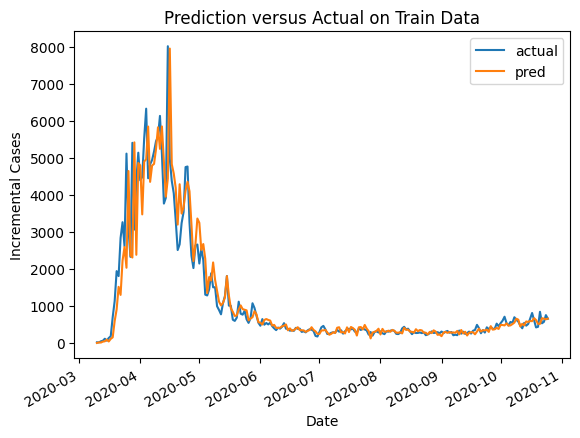

In [ ]:
model = SARIMAX(train.incremental_cases, order = (7, 0, 1), seasonal_order = (1, 0, 2, 30),
                          initialization ='approximate_diffuse').fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.5438738420156023


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

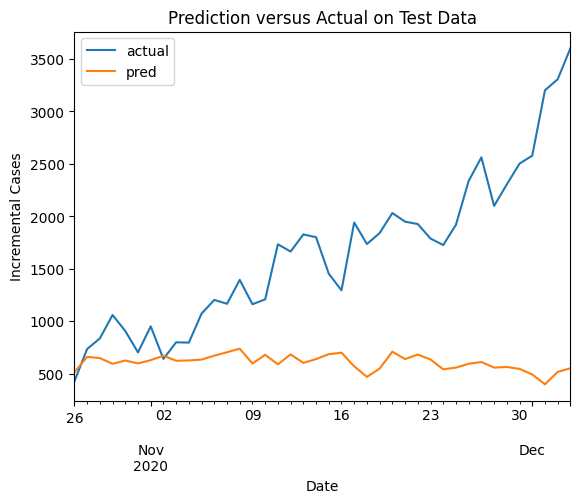

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on test
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

### Auto-ARIMA

In [ ]:
season_param = [(True, 30), (False, 1)]
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')
tscv = TimeSeriesSplit(n_splits = 3, test_size = 40)
best_score, best_param = float("inf"), None

for seasonal in season_param:
  all_mse = 0
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = auto_arima(train_data.incremental_cases, start_p=0, start_q=1, max_p=7, max_q=7, d=0,
                       seasonal=seasonal[0], m=seasonal[1], error_action="ignore")
    mse = mean_squared_error(val_data.incremental_cases, model.predict(n_periods=val_data.shape[0]))
    all_mse = all_mse + mse
  if all_mse / 3 < best_score:
    best_score, best_param = all_mse / 3, model

In [ ]:
best_param

ARIMA(order=(3, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 30),
      suppress_warnings=True, with_intercept=False)

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

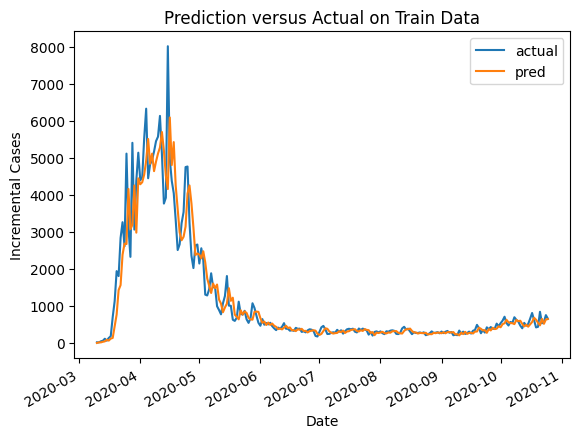

In [ ]:
model = SARIMAX(train.incremental_cases, order = (3, 0, 0), seasonal_order = (0, 0, 0, 30)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = nyc.loc[nyc['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6272046313520858


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

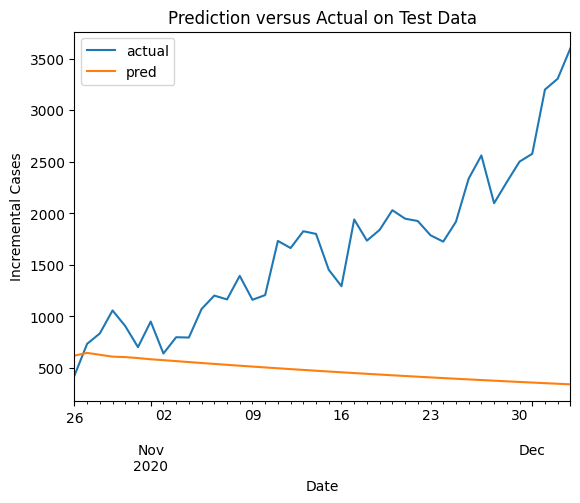

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on test
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

# Clark

(-0.11236379030359746, 0.9481930426302594)
(-3.34492010007454, 0.012986122973227106)


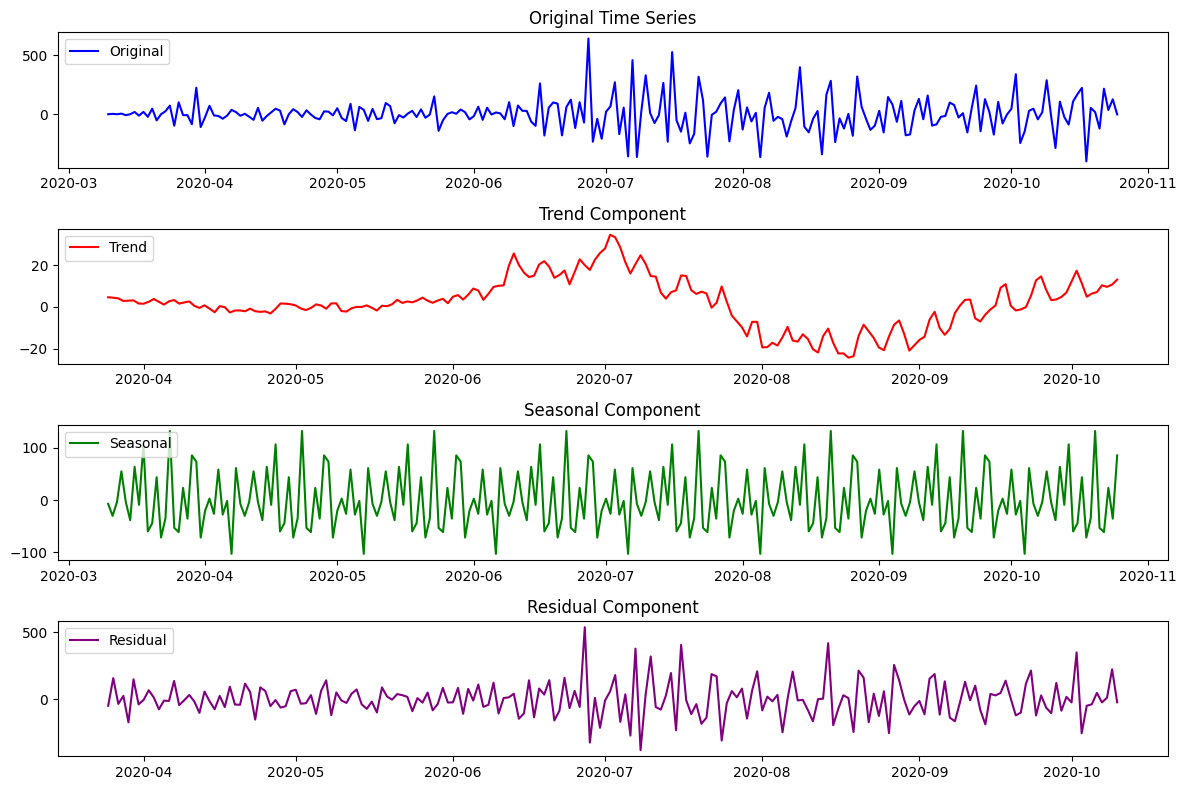

In [ ]:
clark = data[data['county'] == 'Clark'].loc[:, ['date', 'incremental_cases']]
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")

# clark is non-stationary
print(stationary_test(clark.incremental_cases))

# first-level differencing
clark['incremental_cases'] = clark['incremental_cases'].diff(
).fillna(clark['incremental_cases']).astype('int')

# clark is stationary after first-level differencing
print(stationary_test(clark.incremental_cases))

train = clark.iloc[:230, :]
test = clark.iloc[230:, :]

seasonal_check(train)

clark = data[data['county'] == 'Clark'].loc[:, ['date', 'incremental_cases']]
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = clark.iloc[:230, :]
test = clark.iloc[230:, :]

In [ ]:
# prepare data using a combination of d = [0, 1, 2], D = [0, 1, 2], and m = [0, 30]
def differencing(timeseries, m):
    info = []
    for i in range(3):
        timeseries.name = f"d{i}_D0_m0"
        info.append(timeseries)
        timeseries = timeseries.diff()

    for i in m:
        for j in range(3):
            timeseries = info[j].diff(periods=i)
            timeseries.name = f"d{j}_D1_m{i}"
            info.append(timeseries)

    for i in m:
        for j in range(3):
            timeseries = info[j+3].diff(periods=i)
            timeseries.name = f"d{j}_D2_m{i}"
            info.append(timeseries)

    return pd.DataFrame(info).T

diff_series = differencing(train.incremental_cases, [30])
diff_series

,d0_D0_m0,d1_D0_m0,d2_D0_m0,d0_D1_m30,d1_D1_m30,d2_D1_m30,d0_D2_m30,d1_D2_m30,d2_D2_m30
1350,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1351,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1352,3.0,0.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN
1353,8.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1354,0.0,-8.0,-13.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1575,356.0,-122.0,-140.0,228.0,33.0,24.0,589.0,-49.0,-333.0
1576,573.0,217.0,339.0,391.0,163.0,130.0,663.0,74.0,123.0
1577,609.0,36.0,-181.0,184.0,-207.0,-370.0,91.0,-572.0,-646.0
1578,736.0,127.0,91.0,456.0,272.0,479.0,511.0,420.0,992.0


In [ ]:
# check the stationary status of each combination
def adf_summary(diff_series):
    summary = []
    for i in diff_series:
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)

    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]

    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)

    return summary

# only select combinations that are stationary
summary = adf_summary(diff_series)
summary_passed = summary[summary["p-value"] < 0.05]

index_list = pd.Index.tolist(summary_passed.index)
passed_series = diff_series[index_list]
ps = passed_series.sort_index(axis=1)

In [ ]:
ps.columns

Index(['d1_D0_m0', 'd1_D1_m30', 'd1_D2_m30', 'd2_D0_m0', 'd2_D1_m30',
       'd2_D2_m30'],
      dtype='object')

<Axes: title={'center': 'Possible AR Terms'}, xlabel='nth lag', ylabel='Sum of PACF'>

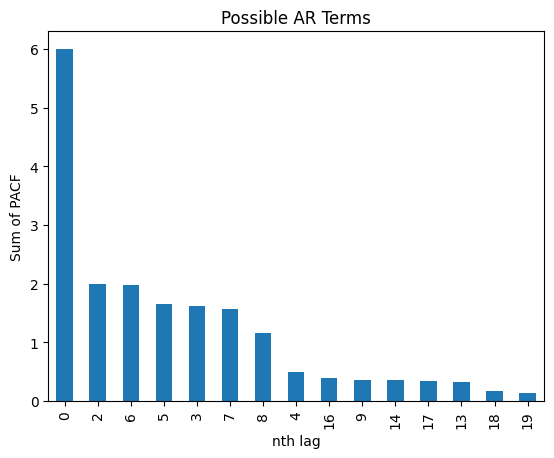

In [ ]:
# visualize the combined ACF and PACF plots to discern possible values for p, q, P, Q

df_sp_p = pd.DataFrame()
AR = []
for i in ps:
    PACF, PACF_ci = pacf(ps[i].dropna(), alpha=0.05, method='ywm')

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF

    # find positions of significant spikes ~ possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]

    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

df_sp_q = pd.DataFrame()
MA = []
for i in ps:
    ACF, ACF_ci = acf(ps[i].dropna(), alpha=0.05)

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF

    # find positions of significant spikes ~ possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]

    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# visualize sums of values of significant spikes by nlags in PACF plots
df_sp_p.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible AR Terms', xlabel='nth lag', ylabel='Sum of PACF')

<Axes: title={'center': 'Possible MA Terms'}, xlabel='nth lag', ylabel='Sum of ACF'>

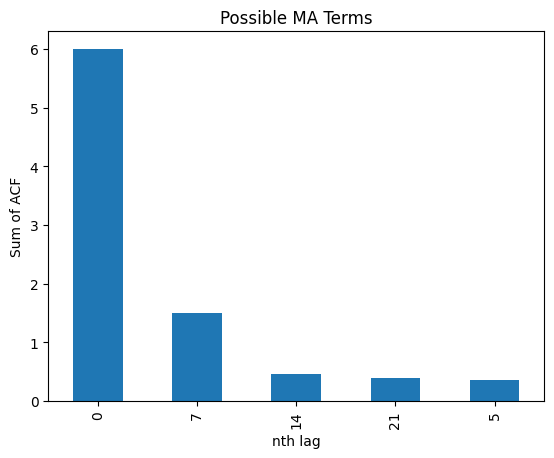

In [ ]:
# visualize sums of values of significant spikes by nlags in ACF plots
df_sp_q.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible MA Terms', xlabel='nth lag', ylabel='Sum of ACF')

In [ ]:
# train ARIMA model with 3-fold CV and possible p, q terms inferred from the above graphs
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 2, 3, 5, 6]
q_values = [0, 7]

best_score, best_param = float("inf"), None

for p in p_values:
    for q in q_values:
      all_mse = 0
      # the "d" parameter is pre-chosen as 1 since Clark is stationary after 1-level of differencing
      param = (p, 1, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 1, 0) with mean MSE: 82406.07499999998
params: (0, 1, 7) with mean MSE: 80699.80453617964
params: (2, 1, 0) with mean MSE: 85979.79027902643
params: (2, 1, 7) with mean MSE: 91901.76957130578
params: (3, 1, 0) with mean MSE: 101958.29330661846
params: (3, 1, 7) with mean MSE: 94126.19930446986
params: (5, 1, 0) with mean MSE: 96012.03591981785
params: (5, 1, 7) with mean MSE: 72481.21317720636
params: (6, 1, 0) with mean MSE: 112618.92437937687
params: (6, 1, 7) with mean MSE: 81459.154269321
Best ARIMA parameters: (5, 1, 7) with mean MSE: 72481.21317720636


<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

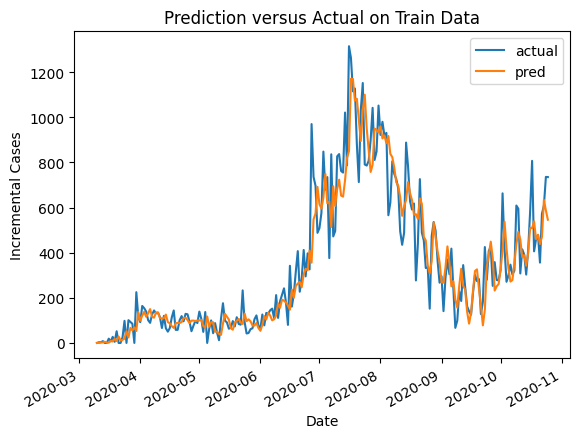

In [ ]:
model = ARIMA(train.incremental_cases, order=(5, 1, 7)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = clark.loc[clark['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4020139816476845


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

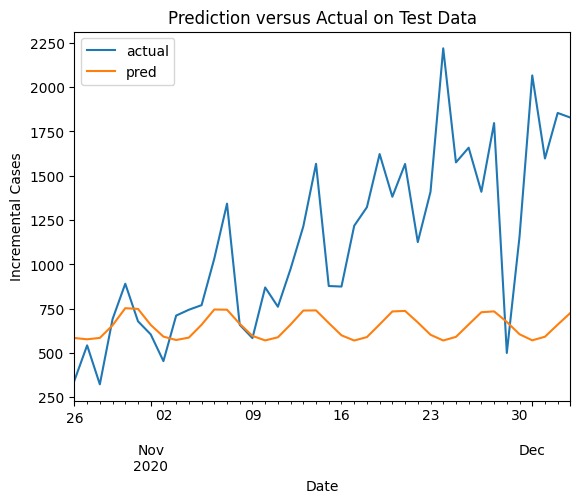

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on train
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = clark.loc[clark['date'] > '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
p_values = [0, 2, 3, 5, 6]
q_values = [0, 7]
P_values = range(0, 3)
Q_values = range(0, 3)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    for P in P_values:
      for Q in Q_values:
        all_mse = 0
        param = (p, 1, q)
        s_param = (P, 1, Q, 30)
        for train_index, val_index in tscv.split(train):
          train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
          model = SARIMAX(train_data.incremental_cases, order = param, seasonal_order = s_param,
                          initialization ='approximate_diffuse').fit()
          mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
          all_mse = all_mse + mse
        print(f'params: {(param, s_param)} with mean MSE: {all_mse / 3}')
        if all_mse / 3 < best_score:
          best_score, best_param, = all_mse / 3, (param, s_param)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: ((0, 1, 0), (0, 1, 0, 30)) with mean MSE: 357656.2916666631
params: ((0, 1, 0), (0, 1, 1, 30)) with mean MSE: 179896.0353689371
params: ((0, 1, 0), (0, 1, 2, 30)) with mean MSE: 183579.32716610414
params: ((0, 1, 0), (1, 1, 0, 30)) with mean MSE: 367330.6683892198
params: ((0, 1, 0), (1, 1, 1, 30)) with mean MSE: 180065.76207289155
params: ((0, 1, 0), (1, 1, 2, 30)) with mean MSE: 170039.53925256574
params: ((0, 1, 0), (2, 1, 0, 30)) with mean MSE: 318197.0711203697
params: ((0, 1, 0), (2, 1, 1, 30)) with mean MSE: 176226.79976084
params: ((0, 1, 0), (2, 1, 2, 30)) with mean MSE: 157653.4531345073
params: ((0, 1, 7), (0, 1, 0, 30)) with mean MSE: 430843.4731014164
params: ((0, 1, 7), (0, 1, 1, 30)) with mean MSE: 173233.8592220276
params: ((0, 1, 7), (0, 1, 2, 30)) with mean MSE: 224246.30805178892
params: ((0, 1, 7), (1, 1, 0, 30)) with mean MSE: 447801.31102142297
params: ((0, 1, 7), (1, 1, 1, 30)) with mean MSE: 203563.26200775872
params: ((0, 1, 7), (1, 1, 2, 30)) with mean

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

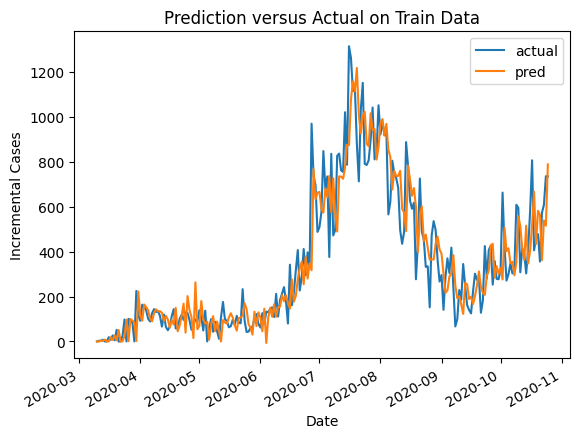

In [ ]:
model = SARIMAX(train.incremental_cases, order=(3, 1, 0), seasonal_order = (2, 1, 2, 30)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = clark.loc[clark['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3678980074047485


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

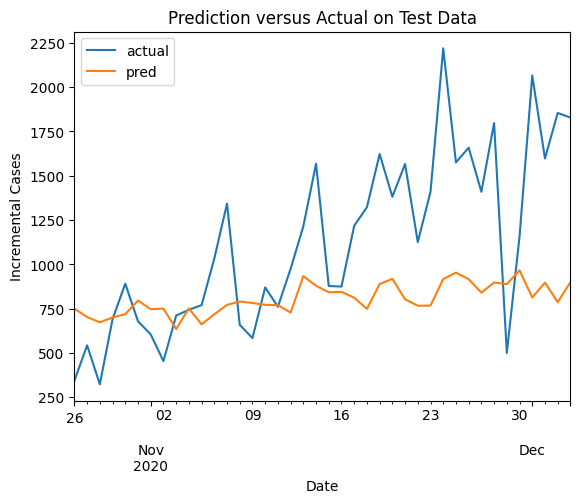

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on train
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = clark.loc[clark['date'] > '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

### Auto-ARIMA

In [ ]:
season_param = [(True, 30), (False, 1)]

best_score, best_param = float("inf"), None

for seasonal in season_param:
  all_mse = 0
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = auto_arima(train_data.incremental_cases, start_p=0, start_q=0, max_p=6, max_q=7, d=1,
                       seasonal=seasonal[0], m=seasonal[1], error_action="ignore")
    mse = mean_squared_error(val_data.incremental_cases, model.predict(n_periods=val_data.shape[0]))
    all_mse = all_mse + mse
  if all_mse / 3 < best_score:
    best_score, best_param = all_mse / 3, model

In [ ]:
best_param

ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

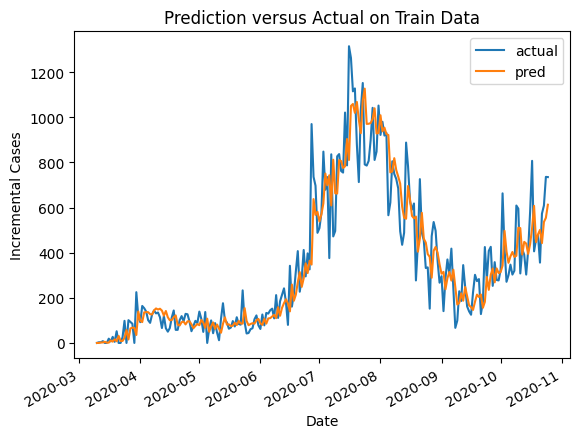

In [ ]:
model = SARIMAX(train.incremental_cases, order=(1, 1, 4), seasonal_order = (0, 0, 0, 0)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = clark.loc[clark['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.35194984113562233


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

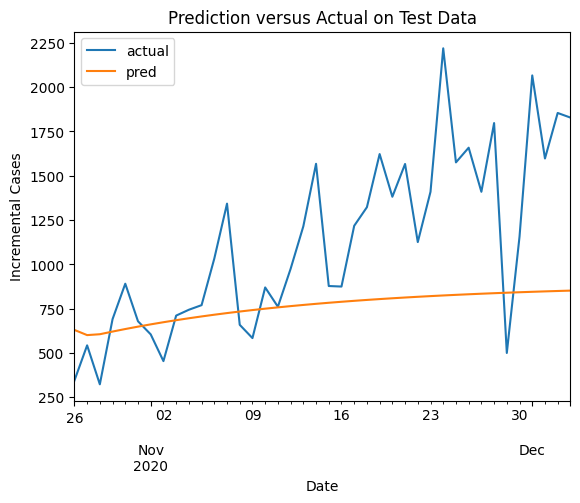

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on train
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = clark.loc[clark['date'] > '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

# Suffolk

(-1.991209666592848, 0.2904406048537438)


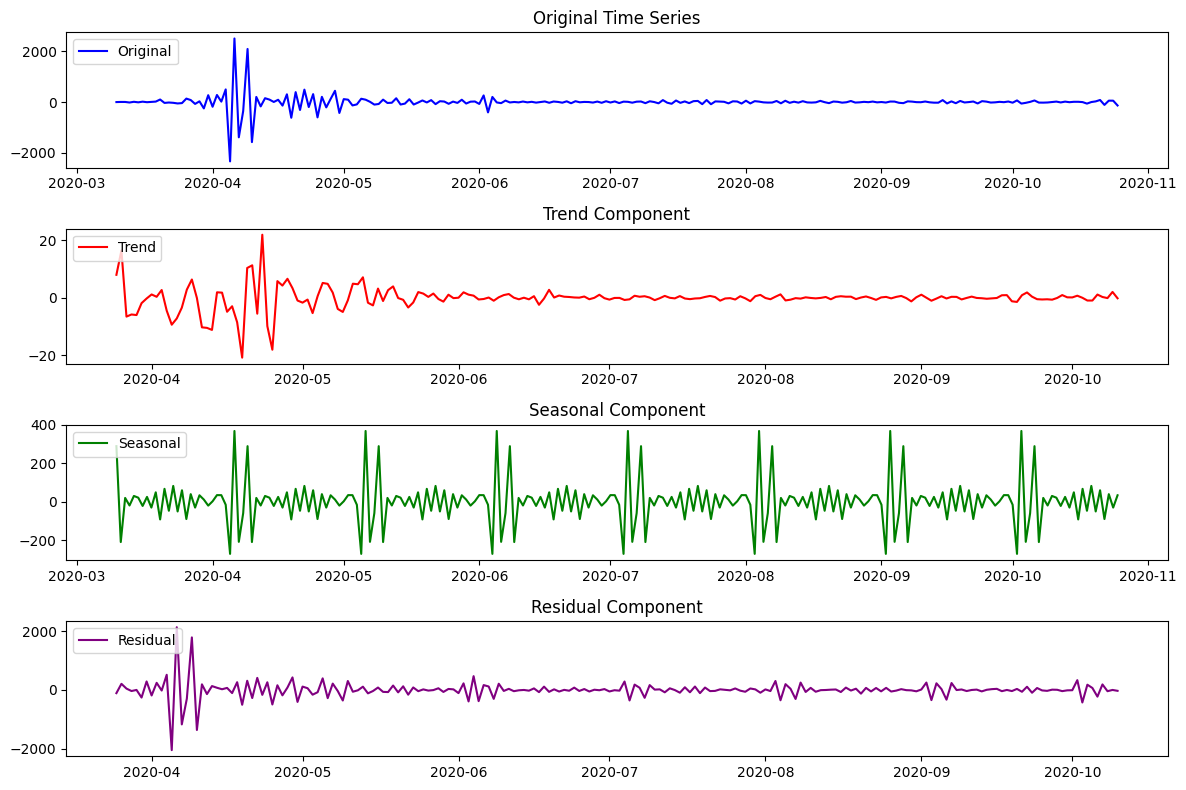

In [ ]:
suffolk = data[data['county'] == 'Suffolk'].loc[:, ['date', 'incremental_cases']]
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")

# suffolk is non-stationary
print(stationary_test(suffolk.incremental_cases))

# first-level differencing
suffolk['incremental_cases'] = suffolk['incremental_cases'].diff(
).fillna(suffolk['incremental_cases']).astype('int')

# suffolk is still non-stationary after first-level differencing
stationary_test(suffolk.incremental_cases)

# second-level differencing
suffolk['incremental_cases'] = suffolk['incremental_cases'].diff(
).fillna(suffolk['incremental_cases']).astype('int')

# suffolk is stationary after second-level differencing
stationary_test(suffolk.incremental_cases)

# use 85%-15% for train-test split
train = suffolk.iloc[:230, :]
test = suffolk.iloc[230:, :]

# check for seasonality
seasonal_check(train)

suffolk = data[data['county'] == 'Suffolk'].loc[:, ['date', 'incremental_cases']]
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = suffolk.iloc[:230, :]
test = suffolk.iloc[230:, :]

In [ ]:
# prepare data using a combination of d = [0, 1, 2], D = [0, 1, 2], and m = [0, 30]
def differencing(timeseries, m):
    info = []
    for i in range(3):
        timeseries.name = f"d{i}_D0_m0"
        info.append(timeseries)
        timeseries = timeseries.diff()

    for i in m:
        for j in range(3):
            timeseries = info[j].diff(periods=i)
            timeseries.name = f"d{j}_D1_m{i}"
            info.append(timeseries)

    for i in m:
        for j in range(3):
            timeseries = info[j+3].diff(periods=i)
            timeseries.name = f"d{j}_D2_m{i}"
            info.append(timeseries)

    return pd.DataFrame(info).T

diff_series = differencing(train.incremental_cases, [30])
diff_series

,d0_D0_m0,d1_D0_m0,d2_D0_m0,d0_D1_m30,d1_D1_m30,d2_D1_m30,d0_D2_m30,d1_D2_m30,d2_D2_m30
2160,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2161,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2162,15.0,10.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
2163,8.0,-7.0,-17.0,NaN,NaN,NaN,NaN,NaN,NaN
2164,12.0,4.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2385,113.0,72.0,82.0,65.0,75.0,82.0,73.0,87.0,92.0
2386,74.0,-39.0,-111.0,7.0,-58.0,-133.0,-18.0,-91.0,-178.0
2387,91.0,17.0,56.0,59.0,52.0,110.0,48.0,66.0,157.0
2388,163.0,72.0,55.0,130.0,71.0,19.0,139.0,91.0,25.0


In [ ]:
# check the stationary status of each combination
def adf_summary(diff_series):
    summary = []
    for i in diff_series:
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)

    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]

    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)

    return summary

# only select combinations that are stationary
summary = adf_summary(diff_series)
summary_passed = summary[summary["p-value"] < 0.05]

index_list = pd.Index.tolist(summary_passed.index)
passed_series = diff_series[index_list]
ps = passed_series.sort_index(axis=1)

In [ ]:
ps.columns

Index(['d0_D1_m30', 'd0_D2_m30', 'd1_D0_m0', 'd1_D1_m30', 'd2_D0_m0',
       'd2_D1_m30', 'd2_D2_m30'],
      dtype='object')

<Axes: title={'center': 'Possible AR Terms'}, xlabel='nth lag', ylabel='Sum of PACF'>

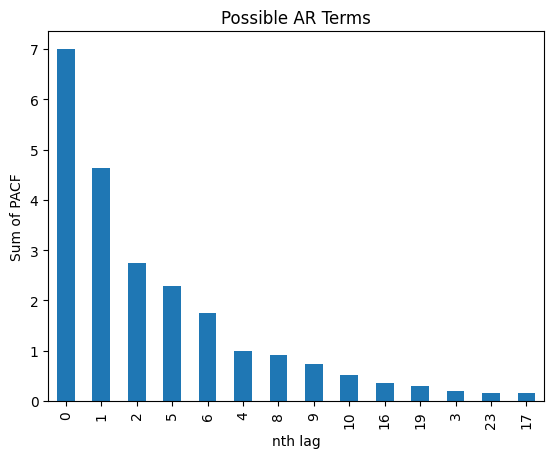

In [ ]:
# visualize the combined ACF and PACF plots to discern possible values for p, q, P, Q

df_sp_p = pd.DataFrame()
AR = []
for i in ps:
    PACF, PACF_ci = pacf(ps[i].dropna(), alpha=0.05, method='ywm')

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    PACF_ci_ll = PACF_ci[:,0] - PACF
    PACF_ci_ul = PACF_ci[:,1] - PACF

    # find positions of significant spikes ~ possible value of p & P
    sp1 = np.where(PACF < PACF_ci_ll)[0]
    sp2 = np.where(PACF > PACF_ci_ul)[0]

    # PACF values of the significant spikes
    sp1_value = abs(PACF[PACF < PACF_ci_ll])
    sp2_value = PACF[PACF > PACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

df_sp_q = pd.DataFrame()
MA = []
for i in ps:
    ACF, ACF_ci = acf(ps[i].dropna(), alpha=0.05)

    # subtract the upper and lower limits of CI by ACF to centre CI at zero
    ACF_ci_ll = ACF_ci[:,0] - ACF
    ACF_ci_ul = ACF_ci[:,1] - ACF

    # find positions of significant spikes ~ possible value of q & Q
    sp1 = np.where(ACF < ACF_ci_ll)[0]
    sp2 = np.where(ACF > ACF_ci_ul)[0]

    # ACF values of the significant spikes
    sp1_value = abs(ACF[ACF < ACF_ci_ll])
    sp2_value = ACF[ACF > ACF_ci_ul]

    sp1_series = pd.Series(sp1_value, index=sp1)
    sp2_series = pd.Series(sp2_value, index=sp2)
    df_sp_q = pd.concat((df_sp_q, sp1_series, sp2_series), axis=1)

# visualize sums of values of significant spikes by nlags in PACF plots
df_sp_p.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible AR Terms', xlabel='nth lag', ylabel='Sum of PACF')

<Axes: title={'center': 'Possible MA Terms'}, xlabel='nth lag', ylabel='Sum of ACF'>

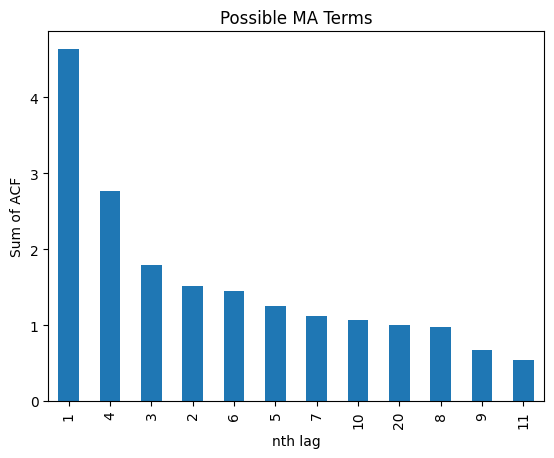

In [ ]:
# visualize sums of values of significant spikes by nlags in ACF plots
df_sp_q.iloc[1:].T.sum().sort_values(ascending = False).plot(kind='bar', title='Possible MA Terms', xlabel='nth lag', ylabel='Sum of ACF')

### ARIMA

In [ ]:
# train ARIMA model with 3-fold CV and possible p, q terms inferred from the above graphs
train = train.loc[:, ['incremental_cases']].reset_index().drop(columns = 'index')

p_values = [0, 1, 2, 5]
q_values = [1, 2, 3 ,4]

best_score, best_param = float("inf"), None

for p in p_values:
    for q in q_values:
      all_mse = 0
      # the "d" parameter is pre-chosen as 2 since Suffolk is stationary after 2-level of differencing
      param = (p, 2, q)
      for train_index, val_index in tscv.split(train):
        train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
        model = ARIMA(train_data.incremental_cases, order = param).fit()
        mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
        all_mse = all_mse + mse
      print(f'params: {param} with mean MSE: {all_mse / 3}')
      if all_mse / 3 < best_score:
        best_score, best_param = all_mse / 3, param

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: (0, 2, 1) with mean MSE: 810.8583969757559
params: (0, 2, 2) with mean MSE: 1398.164120120675
params: (0, 2, 3) with mean MSE: 1210.1409579784313
params: (0, 2, 4) with mean MSE: 1513.1922975003772
params: (1, 2, 1) with mean MSE: 891.0445957239855
params: (1, 2, 2) with mean MSE: 1242.435025911421
params: (1, 2, 3) with mean MSE: 1352.2322722231067
params: (1, 2, 4) with mean MSE: 1179.53624907693
params: (2, 2, 1) with mean MSE: 878.1071669395883
params: (2, 2, 2) with mean MSE: 907.0236881804909
params: (2, 2, 3) with mean MSE: 1345.3629593412923
params: (2, 2, 4) with mean MSE: 1199.5976382483957
params: (5, 2, 1) with mean MSE: 1252.2134910819138
params: (5, 2, 2) with mean MSE: 1596.6674527616526
params: (5, 2, 3) with mean MSE: 1256.395908201671
params: (5, 2, 4) with mean MSE: 1294.1836054835628
Best ARIMA parameters: (0, 2, 1) with mean MSE: 810.8583969757559


<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

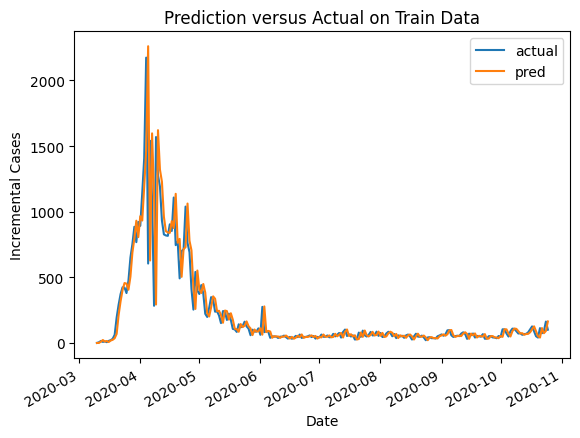

In [ ]:
model = ARIMA(train.incremental_cases, order=(0, 2, 1)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = suffolk.loc[suffolk['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.6386101196842543


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

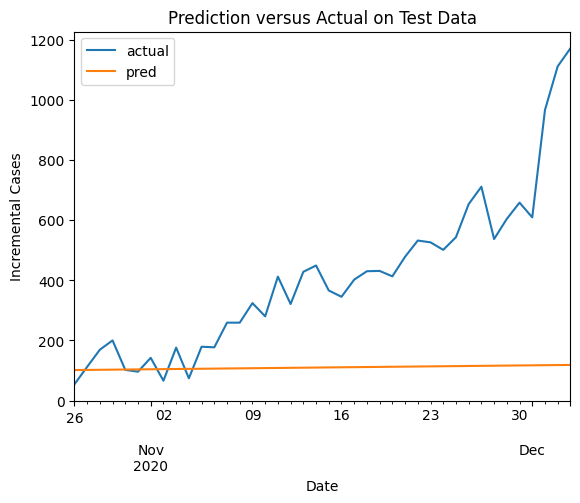

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on train
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = suffolk.loc[suffolk['date'] > '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
p_values = [0, 1, 2, 5]
q_values = [1, 2, 3 ,4]
P_values = range(0, 3)
Q_values = range(0, 3)

best_score, best_param = float("inf"), None

for p in p_values:
  for q in q_values:
    for P in P_values:
      for Q in Q_values:
        all_mse = 0
        param = (p, 2, q)
        s_param = (P, 2, Q, 30)
        for train_index, val_index in tscv.split(train):
          train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
          model = SARIMAX(train_data.incremental_cases, order = param, seasonal_order = s_param,
                          initialization ='approximate_diffuse').fit()
          mse = mean_squared_error(val_data.incremental_cases, model.forecast(steps=val_data.shape[0]))
          all_mse = all_mse + mse
        print(f'params: {(param, s_param)} with mean MSE: {all_mse / 3}')
        if all_mse / 3 < best_score:
          best_score, best_param, = all_mse / 3, (param, s_param)

print(f'Best ARIMA parameters: {best_param} with mean MSE: {best_score}')

params: ((0, 2, 1), (0, 2, 0, 30)) with mean MSE: 1002287.9658677015
params: ((0, 2, 1), (0, 2, 1, 30)) with mean MSE: 1692330.7524284648
params: ((0, 2, 1), (0, 2, 2, 30)) with mean MSE: 2608286.6418631324
params: ((0, 2, 1), (1, 2, 0, 30)) with mean MSE: 1906174.49903003
params: ((0, 2, 1), (1, 2, 1, 30)) with mean MSE: 555844.7026769726
params: ((0, 2, 1), (1, 2, 2, 30)) with mean MSE: 869145.6028425922
params: ((0, 2, 1), (2, 2, 0, 30)) with mean MSE: 5280369.567528973
params: ((0, 2, 1), (2, 2, 1, 30)) with mean MSE: 5350512.0185732115
params: ((0, 2, 1), (2, 2, 2, 30)) with mean MSE: 751314.9308235267
params: ((0, 2, 2), (0, 2, 0, 30)) with mean MSE: 56761.59829295493
params: ((0, 2, 2), (0, 2, 1, 30)) with mean MSE: 891750.9132989935
params: ((0, 2, 2), (0, 2, 2, 30)) with mean MSE: 1578232.1018954767
params: ((0, 2, 2), (1, 2, 0, 30)) with mean MSE: 741284.7038331759
params: ((0, 2, 2), (1, 2, 1, 30)) with mean MSE: 132709.4239023957
params: ((0, 2, 2), (1, 2, 2, 30)) with mean

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

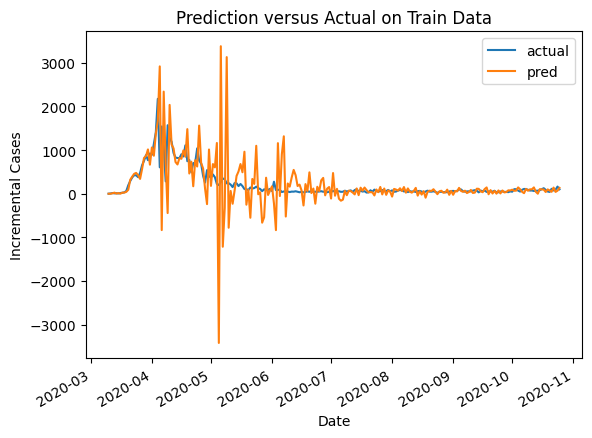

In [ ]:
model = SARIMAX(train.incremental_cases, order=(1, 2, 4), seasonal_order = (0, 2, 0, 30)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = suffolk.loc[suffolk['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4230839887511717


<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

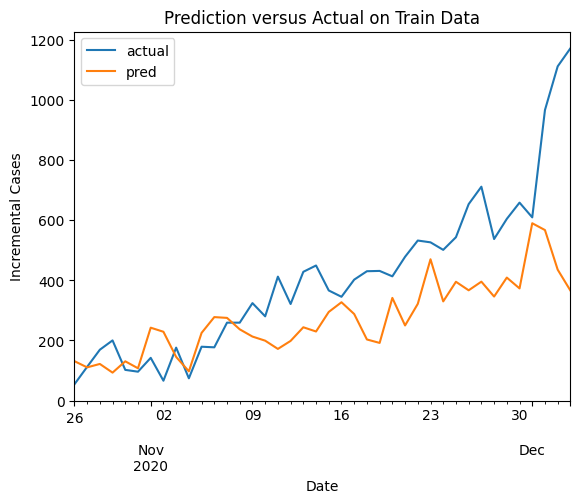

In [ ]:
pred = model.forecast(steps = 40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on train
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = suffolk.loc[suffolk['date'] > '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

### Auto-ARIMA

In [ ]:
season_param = [(True, 30), (False, 1)]
best_score, best_param = float("inf"), None

for seasonal in season_param:
  all_mse = 0
  for train_index, val_index in tscv.split(train):
    train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
    model = auto_arima(train_data.incremental_cases, start_p=0, start_q=1, max_p=5, max_q=4, d=2, D=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, seasonal=seasonal[0], m=seasonal[1],
                       error_action="ignore")
    mse = mean_squared_error(val_data.incremental_cases, model.predict(n_periods=val_data.shape[0]))
    all_mse = all_mse + mse
  if all_mse / 3 < best_score:
    best_score, best_param = all_mse / 3, model

KeyError: "None of [Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n            ...\n            100, 101, 102, 103, 104, 105, 106, 107, 108, 109],\n           dtype='int64', length=110)] are in the [index]"

In [ ]:
best_param

ARIMA(order=(4, 2, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

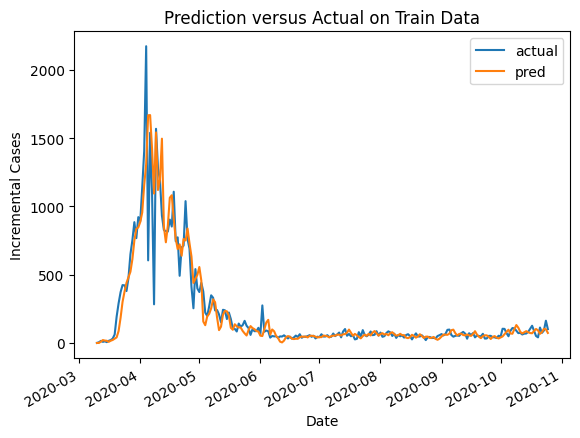

In [ ]:
model = SARIMAX(train.incremental_cases, order=(4, 2, 3), seasonal_order = (0, 0, 0, 0)).fit()
pred = model.predict(start = 0, end = 230)

# plot prediction on train
prediction = pd.DataFrame({'actual':train.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = suffolk.loc[suffolk['date'] <= '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.5079153246247005


<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

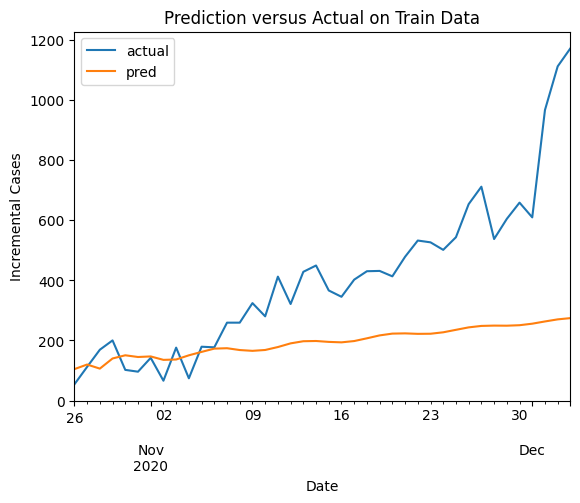

In [ ]:
pred = model.forecast(steps=40)
mape = mean_absolute_percentage_error(test.incremental_cases, pred)
print(mape)

# plot prediction on train
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = suffolk.loc[suffolk['date'] > '2020-10-25', 'date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')